# Basic RSI strategy

## Single backtest

In [1]:
import numpy as np
import pandas as pd

In [2]:
import vectorbtpro as vbt

vbt.settings.set_theme('dark')

In [3]:
data = vbt.BinanceData.fetch('BTCUSDT')
data

0it [00:00, ?it/s]

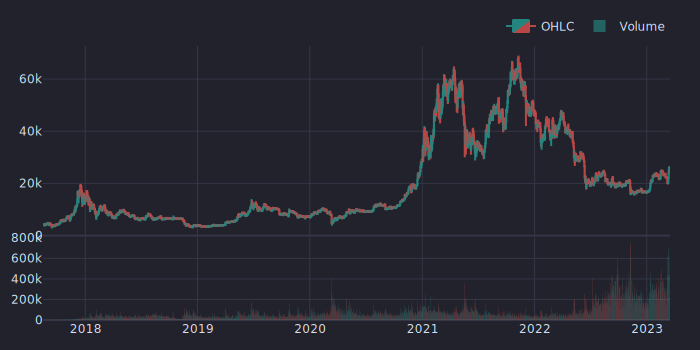

In [4]:
data.data['BTCUSDT'].vbt.ohlcv.plot().show_svg()

In [5]:
data.data['BTCUSDT'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2017-08-17 00:00:00+00:00 to 2023-03-17 00:00:00+00:00
Freq: D
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2039 non-null   float64
 1   High                2039 non-null   float64
 2   Low                 2039 non-null   float64
 3   Close               2039 non-null   float64
 4   Volume              2039 non-null   float64
 5   Quote volume        2039 non-null   float64
 6   Trade count         2039 non-null   int64  
 7   Taker base volume   2039 non-null   float64
 8   Taker quote volume  2039 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 159.3 KB


In [6]:
open_price = data.get('Open')
close_price = data.get('Close')

In [7]:
vbt.IF.list_indicators("RSI*")

/Users/olegpolakow/Documents/GitHub/vectorbt.pro/vectorbtpro/utils/parsing.py:347: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



['vbt:RSI', 'talib:RSI', 'pandas_ta:RSI', 'ta:RSIIndicator', 'technical:RSI']

In [8]:
vbt.indicator("talib:RSI")

vectorbtpro.indicators.factory.talib.RSI

In [8]:
vbt.RSI

vectorbtpro.indicators.custom.RSI

In [9]:
vbt.talib('RSI')

vectorbtpro.indicators.factory.talib.RSI

In [10]:
vbt.ta('RSIIndicator')

vectorbtpro.indicators.factory.ta.RSIIndicator

In [11]:
vbt.pandas_ta('RSI')

vectorbtpro.indicators.factory.pandas_ta.RSI

In [13]:
print(vbt.format_func(vbt.RSI.run))

RSI.run(
    close,
    window=Default(value=14),
    wtype=Default(value='wilder'),
    short_name='rsi',
    hide_params=None,
    hide_default=True,
    **kwargs
):
    Run `RSI` indicator.
    
    * Inputs: `close`
    * Parameters: `window`, `wtype`
    * Outputs: `rsi`
    
    Pass a list of parameter names as `hide_params` to hide their column levels.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `vectorbtpro.indicators.factory.run_pipeline`.


In [14]:
rsi = vbt.RSI.run(open_price)
rsi

In [15]:
rsi.rsi

Open time
2017-08-17 00:00:00+00:00          NaN
2017-08-18 00:00:00+00:00          NaN
2017-08-19 00:00:00+00:00          NaN
2017-08-20 00:00:00+00:00          NaN
2017-08-21 00:00:00+00:00          NaN
                               ...    
2022-07-30 00:00:00+00:00    60.541637
2022-07-31 00:00:00+00:00    59.503179
2022-08-01 00:00:00+00:00    56.750576
2022-08-02 00:00:00+00:00    56.512434
2022-08-03 00:00:00+00:00    54.177385
Freq: D, Name: Open, Length: 1813, dtype: float64

In [18]:
entries = rsi.rsi.vbt.crossed_below(30)
entries

Open time
2017-08-17 00:00:00+00:00    False
2017-08-18 00:00:00+00:00    False
2017-08-19 00:00:00+00:00    False
2017-08-20 00:00:00+00:00    False
2017-08-21 00:00:00+00:00    False
                             ...  
2022-07-30 00:00:00+00:00    False
2022-07-31 00:00:00+00:00    False
2022-08-01 00:00:00+00:00    False
2022-08-02 00:00:00+00:00    False
2022-08-03 00:00:00+00:00    False
Freq: D, Name: Open, Length: 1813, dtype: bool

In [19]:
exits = rsi.rsi.vbt.crossed_above(70)
exits

Open time
2017-08-17 00:00:00+00:00    False
2017-08-18 00:00:00+00:00    False
2017-08-19 00:00:00+00:00    False
2017-08-20 00:00:00+00:00    False
2017-08-21 00:00:00+00:00    False
                             ...  
2022-07-30 00:00:00+00:00    False
2022-07-31 00:00:00+00:00    False
2022-08-01 00:00:00+00:00    False
2022-08-02 00:00:00+00:00    False
2022-08-03 00:00:00+00:00    False
Freq: D, Name: Open, Length: 1813, dtype: bool

In [20]:
entries = rsi.rsi_crossed_below(30)
exits = rsi.rsi_crossed_above(70)

In [21]:
def plot_rsi(rsi, entries, exits):
    fig = rsi.plot()
    entries.vbt.signals.plot_as_entries(rsi.rsi, fig=fig)
    exits.vbt.signals.plot_as_exits(rsi.rsi, fig=fig)
    return fig

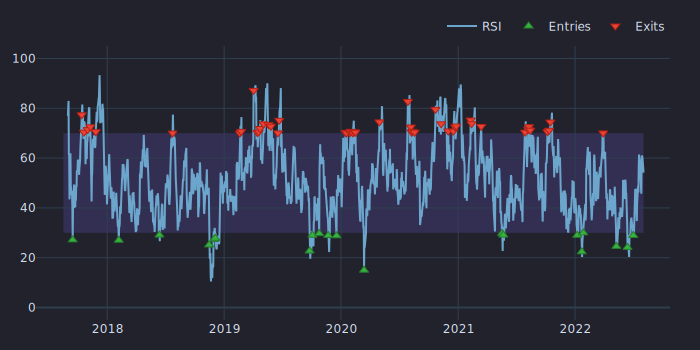

In [22]:
plot_rsi(rsi, entries, exits).show_svg()

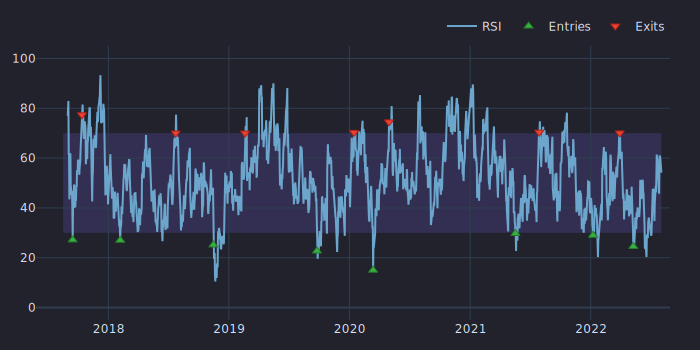

In [23]:
clean_entries, clean_exits = entries.vbt.signals.clean(exits)

plot_rsi(rsi, clean_entries, clean_exits).show_svg()

In [24]:
clean_entries.vbt.signals.total()

8

In [25]:
clean_exits.vbt.signals.total()

7

In [26]:
ranges = clean_entries.vbt.signals.between_ranges(other=clean_exits)
ranges.duration.mean(wrap_kwargs=dict(to_timedelta=True))

Timedelta('86 days 10:17:08.571428572')

In [28]:
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=clean_entries, 
    exits=clean_exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
pf

In [31]:
pf.stats()

Start                         2017-08-17 00:00:00+00:00
End                           2022-08-03 00:00:00+00:00
Period                               1813 days 00:00:00
Start Value                                       100.0
Min Value                                     97.185676
Max Value                                    203.182943
End Value                                    171.335425
Total Return [%]                              71.335425
Benchmark Return [%]                         446.481746
Total Time Exposure [%]                       38.113624
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              46.385941
Max Drawdown Duration                1613 days 00:00:00
Total Orders                                         15
Total Fees Paid                                     0.0
Total Trades                                          8
Win Rate [%]                                  71.428571
Best Trade [%]                                54

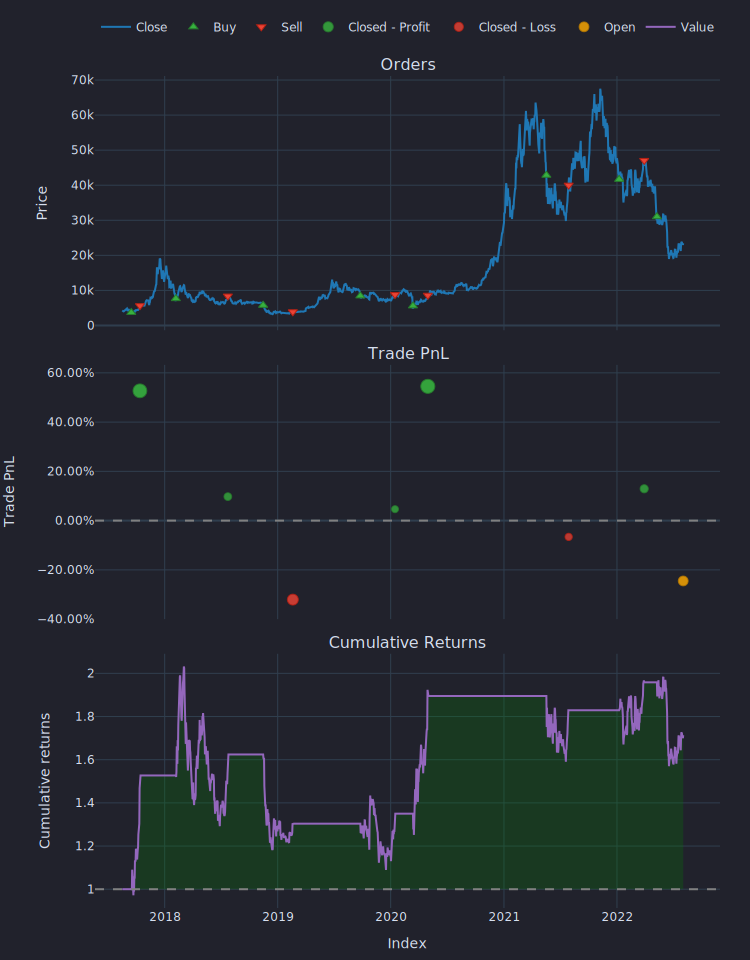

In [32]:
pf.plot(settings=dict(bm_returns=False)).show_svg()

## Multiple backtests

### Using for-loop

In [33]:
def test_rsi(window=14, wtype="wilder", lower_th=30, upper_th=70):
    rsi = vbt.RSI.run(open_price, window=window, wtype=wtype)
    entries = rsi.rsi_crossed_below(lower_th)
    exits = rsi.rsi_crossed_above(upper_th)
    pf = vbt.Portfolio.from_signals(
        close=close_price, 
        entries=entries, 
        exits=exits,
        size=100,
        size_type='value',
        init_cash='auto')
    return pf.stats([
        'total_return', 
        'total_trades', 
        'win_rate', 
        'expectancy'
    ])

In [34]:
test_rsi()

Total Return [%]    71.335425
Total Trades                8
Win Rate [%]        71.428571
Expectancy          13.691111
dtype: object

In [37]:
test_rsi(lower_th=20, upper_th=80)

Total Return [%]    6.652287
Total Trades               2
Win Rate [%]            50.0
Expectancy          3.737274
dtype: object

In [38]:
from itertools import product

lower_ths = range(20, 31)
upper_ths = range(70, 81)
th_combs = list(product(lower_ths, upper_ths))
len(th_combs)

121

In [41]:
comb_stats = [
    test_rsi(lower_th=lower_th, upper_th=upper_th)
    for lower_th, upper_th in th_combs
]

In [43]:
comb_stats_df = pd.DataFrame(comb_stats)
print(comb_stats_df)

     Total Return [%]  Total Trades  Win Rate [%]  Expectancy
0           24.369550             3     66.666667   10.606342
1           37.380341             3     66.666667   16.203667
2           34.560194             3     66.666667   14.981187
3           31.090080             3     66.666667   13.833710
4           31.090080             3     66.666667   13.833710
..                ...           ...           ...         ...
116         51.074571             6     80.000000   18.978193
117         62.853840             6     80.000000   21.334047
118         40.685579             5     75.000000   21.125494
119         -5.990835             4     66.666667   13.119897
120        -10.315159             4     66.666667   11.678455

[121 rows x 4 columns]


In [44]:
comb_stats_df.index = pd.MultiIndex.from_tuples(
    th_combs, 
    names=['lower_th', 'upper_th'])
print(comb_stats_df)

                   Total Return [%]  Total Trades  Win Rate [%]  Expectancy
lower_th upper_th                                                          
20       70               24.369550             3     66.666667   10.606342
         71               37.380341             3     66.666667   16.203667
         72               34.560194             3     66.666667   14.981187
         73               31.090080             3     66.666667   13.833710
         74               31.090080             3     66.666667   13.833710
...                             ...           ...           ...         ...
30       76               51.074571             6     80.000000   18.978193
         77               62.853840             6     80.000000   21.334047
         78               40.685579             5     75.000000   21.125494
         79               -5.990835             4     66.666667   13.119897
         80              -10.315159             4     66.666667   11.678455

[121 rows x

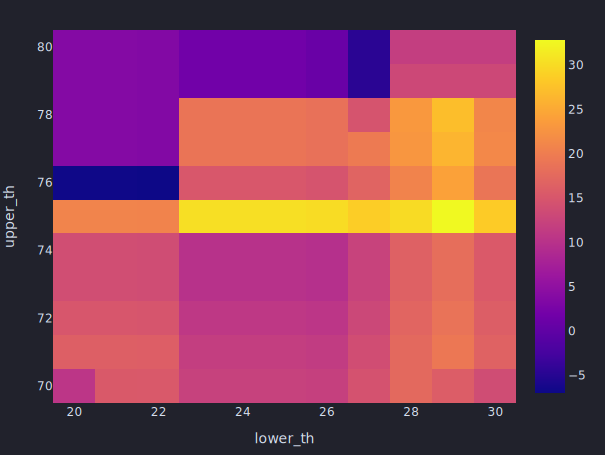

In [45]:
comb_stats_df['Expectancy'].vbt.heatmap().show_svg()

### Using columns

In [47]:
windows = list(range(8, 21))
wtypes = ["simple", "exp", "wilder"]
lower_ths = list(range(20, 31))
upper_ths = list(range(70, 81))

In [48]:
rsi = vbt.RSI.run(
    open_price, 
    window=windows, 
    wtype=wtypes, 
    param_product=True)
rsi.rsi.columns

MultiIndex([( 8, 'simple'),
            ( 8,    'exp'),
            ( 8, 'wilder'),
            ( 9, 'simple'),
            ( 9,    'exp'),
            ( 9, 'wilder'),
            (10, 'simple'),
            (10,    'exp'),
            (10, 'wilder'),
            (11, 'simple'),
            (11,    'exp'),
            (11, 'wilder'),
            (12, 'simple'),
            (12,    'exp'),
            (12, 'wilder'),
            (13, 'simple'),
            (13,    'exp'),
            (13, 'wilder'),
            (14, 'simple'),
            (14,    'exp'),
            (14, 'wilder'),
            (15, 'simple'),
            (15,    'exp'),
            (15, 'wilder'),
            (16, 'simple'),
            (16,    'exp'),
            (16, 'wilder'),
            (17, 'simple'),
            (17,    'exp'),
            (17, 'wilder'),
            (18, 'simple'),
            (18,    'exp'),
            (18, 'wilder'),
            (19, 'simple'),
            (19,    'exp'),
            (19, 'wi

In [50]:
lower_ths_prod, upper_ths_prod = zip(*product(lower_ths, upper_ths))
len(lower_ths_prod)

121

In [51]:
len(upper_ths_prod)

121

In [53]:
lower_th_index = vbt.Param(lower_ths_prod, name='lower_th')
entries = rsi.rsi_crossed_below(lower_th_index)
entries.columns

MultiIndex([(20,  8, 'simple'),
            (20,  8,    'exp'),
            (20,  8, 'wilder'),
            (20,  9, 'simple'),
            (20,  9,    'exp'),
            (20,  9, 'wilder'),
            (20, 10, 'simple'),
            (20, 10,    'exp'),
            (20, 10, 'wilder'),
            (20, 11, 'simple'),
            ...
            (30, 17, 'wilder'),
            (30, 18, 'simple'),
            (30, 18,    'exp'),
            (30, 18, 'wilder'),
            (30, 19, 'simple'),
            (30, 19,    'exp'),
            (30, 19, 'wilder'),
            (30, 20, 'simple'),
            (30, 20,    'exp'),
            (30, 20, 'wilder')],
           names=['lower_th', 'rsi_window', 'rsi_wtype'], length=4719)

In [54]:
upper_th_index = vbt.Param(upper_ths_prod, name='upper_th')
exits = rsi.rsi_crossed_above(upper_th_index)
exits.columns

MultiIndex([(70,  8, 'simple'),
            (70,  8,    'exp'),
            (70,  8, 'wilder'),
            (70,  9, 'simple'),
            (70,  9,    'exp'),
            (70,  9, 'wilder'),
            (70, 10, 'simple'),
            (70, 10,    'exp'),
            (70, 10, 'wilder'),
            (70, 11, 'simple'),
            ...
            (80, 17, 'wilder'),
            (80, 18, 'simple'),
            (80, 18,    'exp'),
            (80, 18, 'wilder'),
            (80, 19, 'simple'),
            (80, 19,    'exp'),
            (80, 19, 'wilder'),
            (80, 20, 'simple'),
            (80, 20,    'exp'),
            (80, 20, 'wilder')],
           names=['upper_th', 'rsi_window', 'rsi_wtype'], length=4719)

In [56]:
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=entries, 
    exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
pf

667 ms ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
stats_df = pf.stats([
    'total_return', 
    'total_trades', 
    'win_rate', 
    'expectancy'
], agg_func=None)
print(stats_df)

                                        Total Return [%]  Total Trades  \
lower_th upper_th rsi_window rsi_wtype                                   
20       70       8          simple           -25.285842            31   
                             exp               -7.939736            29   
                             wilder            61.979801            11   
                  9          simple           -71.673138            23   
                             exp              -10.653263            25   
...                                                  ...           ...   
30       80       19         exp               13.967965             8   
                             wilder           -20.990411             3   
                  20         simple           -59.159157             4   
                             exp               -3.331163             8   
                             wilder            31.479482             3   

                                     

In [60]:
>>> print(pf.getsize())

9.4 MB


In [64]:
>>> np.product(pf.wrapper.shape) * 8 / 1024 / 1024

65.27364349365234

In [65]:
stats_df['Expectancy'].groupby('rsi_window').mean()

rsi_window
8      0.154425
9      0.064130
10    -0.915478
11    -0.523294
12     0.742266
13     3.898482
14     4.414367
15     6.916872
16     8.915225
17    12.204188
18    12.897135
19    14.508950
20    16.429515
Name: Expectancy, dtype: float64

In [66]:
print(stats_df.sort_values(by='Expectancy', ascending=False).head())

                                        Total Return [%]  Total Trades  \
lower_th upper_th rsi_window rsi_wtype                                   
22       80       20         wilder           187.478208             2   
21       80       20         wilder           187.478208             2   
26       80       20         wilder           152.087039             3   
23       80       20         wilder           187.478208             2   
25       80       20         wilder           201.297495             3   

                                        Win Rate [%]  Expectancy  
lower_th upper_th rsi_window rsi_wtype                            
22       80       20         wilder            100.0   93.739104  
21       80       20         wilder            100.0   93.739104  
26       80       20         wilder            100.0   93.739104  
23       80       20         wilder            100.0   93.739104  
25       80       20         wilder            100.0   93.739104  


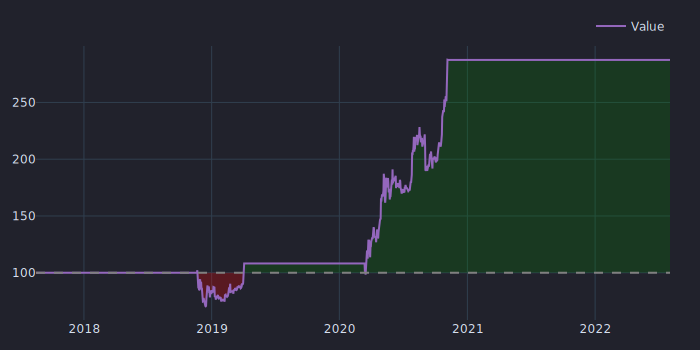

In [67]:
pf[(22, 80, 20, "wilder")].plot_value().show_svg()

In [68]:
data = vbt.BinanceData.fetch(['BTCUSDT', 'ETHUSDT'])

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [69]:
open_price = data.get('Open')
close_price = data.get('Close')

In [71]:
rsi = vbt.RSI.run(
    open_price, 
    window=windows, 
    wtype=wtypes, 
    param_product=True)
entries = rsi.rsi_crossed_below(lower_th_index)
exits = rsi.rsi_crossed_above(upper_th_index)
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=entries, 
    exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
stats_df = pf.stats([
    'total_return', 
    'total_trades', 
    'win_rate', 
    'expectancy'
], agg_func=None)

/Users/olegpolakow/Documents/GitHub/vectorbt.pro/vectorbtpro/portfolio/base.py:9220: RuntimeWarning:

invalid value encountered in true_divide



In [73]:
stats_df.index

MultiIndex([(20, 70,  8, 'simple', 'BTCUSDT'),
            (20, 70,  8, 'simple', 'ETHUSDT'),
            (20, 70,  8,    'exp', 'BTCUSDT'),
            (20, 70,  8,    'exp', 'ETHUSDT'),
            (20, 70,  8, 'wilder', 'BTCUSDT'),
            (20, 70,  8, 'wilder', 'ETHUSDT'),
            (20, 70,  9, 'simple', 'BTCUSDT'),
            (20, 70,  9, 'simple', 'ETHUSDT'),
            (20, 70,  9,    'exp', 'BTCUSDT'),
            (20, 70,  9,    'exp', 'ETHUSDT'),
            ...
            (30, 80, 19,    'exp', 'BTCUSDT'),
            (30, 80, 19,    'exp', 'ETHUSDT'),
            (30, 80, 19, 'wilder', 'BTCUSDT'),
            (30, 80, 19, 'wilder', 'ETHUSDT'),
            (30, 80, 20, 'simple', 'BTCUSDT'),
            (30, 80, 20, 'simple', 'ETHUSDT'),
            (30, 80, 20,    'exp', 'BTCUSDT'),
            (30, 80, 20,    'exp', 'ETHUSDT'),
            (30, 80, 20, 'wilder', 'BTCUSDT'),
            (30, 80, 20, 'wilder', 'ETHUSDT')],
           names=['lower_th', 'upper_th', '

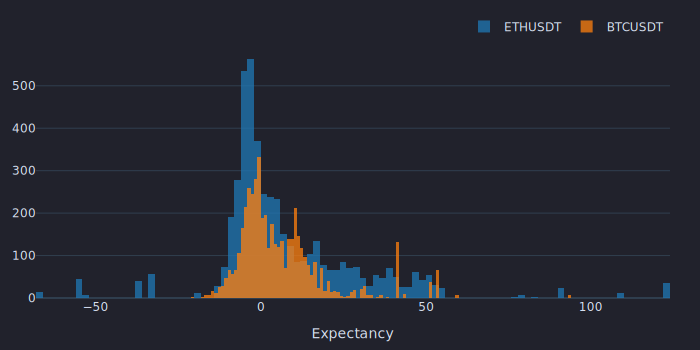

In [74]:
eth_mask = stats_df.index.get_level_values('symbol') == 'ETHUSDT'
btc_mask = stats_df.index.get_level_values('symbol') == 'BTCUSDT'
pd.DataFrame({
    'ETHUSDT': stats_df[eth_mask]['Expectancy'].values,
    'BTCUSDT': stats_df[btc_mask]['Expectancy'].values
}).vbt.histplot(xaxis=dict(title="Expectancy")).show_svg()